# Packet Classification for Mobile Applications

*Author : Mahsa Dinarvand*

![image](https://gdpr.report/wp-content/uploads/2019/08/media-998990_1280-1-e1567164854224-635x360.jpg)

# 1- Importing Libraries

In [1]:
import time
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
!pip install fastdtw
from fastdtw import fastdtw
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.model_selection import train_test_split

# 2- Clustering

## 2-1- Functions

In [2]:
def load_raw_data(path):
    """
    Loads the dataset using Pandas
    We just need some of the columns, for clusering purposes we just need 'packets_length_total',
    the others are needed to link flows to their respective actions
    parameters:
    path: dataset path
    
    return:
    list of flows,
    """
    df = pd.read_csv(path)
    # extracting useful data
    data = df.loc[ENV_STARTING_INDEX:ENV_LAST_INDEX, ["action_start", "packets_length_total", "action"]].values
    # converting flows to actual lists

    return [_str_to_list(row[1]) for row in data], data[:, [0, 2]]


In [3]:
def _str_to_list(s):
    """
    This functions expects strings in the form of s = '[n1, n2, ...]'
    as loaded from the original dataset. With these kind of variables
    we have that s[0] is '[' while we want it to be n1.
    To make them useful i need to convert them to actual lists.
    parameters:
    s: list-looking-like string
    
    return: 
    the actual list represented by the string
    """
    return [int(sub.replace("[", "").replace("]", "")) for sub in s.split(",")]


In [4]:
# manhattan distance
def _abs(x1, x2):
    """
    function used by DTW, it's just the absolute value of the difference
    also known as cityblock distance or manhattan distance
    parameters:
    x1: first element
    x2: second element
    
    return:
    absolute value of x1-x2
    """
    return abs(x1 - x2)

In [5]:

def cdm(flows, dist_func=_abs):
    """
    building the Condensed Distance Matrix (CDM).
    
    parameters:
    flows: the list of flows loaded from the dataset
    dist_func: the dist function that will be passed to DTW
    
    return:
    a CDM, ideally every entry (i, j) contains dtw(i, j)
    """
    return [fastdtw(flows[i], flows[j], dist=dist_func)[0]
            for i in range(N_FLOWS)
            for j in range(i + 1, N_FLOWS)]

In [6]:
def clustering(cdm, linkage_metric="average"):
    # cdm: precomputed condensed distance matrix
    # memory issues for large number of flows
    Z = linkage(cdm, method=linkage_metric)
    return fcluster(Z, N_CLUSTERS, criterion='maxclust')


In [7]:
def prepare_samples(clusters, data):
    """
    parameters:
    clusters: the output of `clustering`, its length is N_FLOWS, each entry has a value
    in [1, N_CLUSTERS] which denotes the cluster assigned to the i-th entry (or flow).
    data: data containing "action ids" and action labels, the i-th entry of data contains the action_label
    and "action id" of the i-th entry of `clusters`. It is needed to link flows to their actions.
    
    return:
    samples, action representation using clustering info, read comments for more info.
    """
    samples = []
    features = np.zeros(N_CLUSTERS)

    # settings these two values allows me not to check for None values
    prev_action_id = data[0][0]
    prev_action_label = data[0][1]

    for idx, row in enumerate(data):
        # saving current action_{label, id}
        cur_action_id = row[0]
        cur_action_label = row[1]
        if prev_action_id != cur_action_id:
            # if we just passed to a new action
            # we have to save the current features and reset
            # save data retrieved till now (action, features)
            samples.append((prev_action_label, features))
            # reset features for next action
            features = np.zeros(N_CLUSTERS)

        # res[idx] = cluster associated with the idx-th flow
        # features[res[idx]] number of elements in the res[idx]-th cluster for this action
        # NB: clusters are numbered starting from 1, so we need res[idx] to be res[idx]-1  when used as index
        features[clusters[idx] - 1] += 1

        # updating
        prev_action_label = cur_action_label
        prev_action_id = cur_action_id

        if idx+1 == N_FLOWS:
            # no more flows to analyze
            # saving this one
            samples.append((prev_action_label, features))

    return samples


In [8]:
def save_dataset(samples):
    """
    Function that actually saves the dataset and adds the headers to it, basically converts a numpy array to a csv file.
    
    parameters: 
    samples: output of `prepare_samples`, a list of samples (actions) with |N_CLUSTERS| integer features plus
    the "target" being the action label.
    
    return:
    None
    """
    # writing dataset to csv file
    with open('./{}_dataset_{}.csv'.format(app_name, N_CLUSTERS), 'w') as f:
        # building headers
        # C1, C2,..., Cn, action
        headers = ""
        for i in range(N_CLUSTERS):
            headers += "C{},".format(i + 1)
        headers += "action\n"
        f.write(headers)

        # data rows
        # first clusters, then action label
        # row[0] = action label
        # row[1] = list of cluters (features)
        for row in samples:
            for c in row[1]:
                f.write("{},".format(int(c)))
            f.write("\"{}\"\n".format(row[0]))

## 2-2- Code execution

In [12]:
apps_flows = dict(facebook=(0, 9829), twitter=(50319, 60742), gmail=(86578, 96501), gplus=(96502, 107293),
               tumblr=(129973, 140532), dropbox=(186675, 196682), evernote=(235137, 246620))

In [17]:

N_CLUSTERS = 250  # --> 250 seems to be optimal
PATH = "./apps_total_plus_filtered.csv"

    # F: flows loaded from dataset
    # D: F but with more features, needed later
    # X: condensed distance matrix (upper triangular matrix)
    # C: list with cluster assignments for each flow in D

apps = ['facebook','gmail','dropbox','twitter','tumblr','gplus','evernote']    
# it take a considerable amount of time to run each cdm. so, it would definitely
#last ages to run in a loop . as a result, please choose each
# app separately to receive a clustering batch

app_name = "facebook" # change the app name manually
ENV_STARTING_INDEX = 0 #apps_flows[app_name][0]
ENV_LAST_INDEX =  10 #apps_flows[app_name][1]

F, D = load_raw_data(path=PATH)
N_FLOWS = len(F)

In [18]:
start_time = time.time()

print("Building CDM... ")
X = cdm(flows=F, dist_func=_abs)
    
print(" It took {:.3f}s to build a condensed distance matrix]".format(time.time() - start_time))

Building CDM... 
 It took 0.081s to build a condensed distance matrix]


In [192]:
#Clustering and Linking
C = clustering(cdm=X, linkage_metric="average")

# Creating Dataset
dataset = prepare_samples(clusters=C, data=D)

#Saving Dataset
save_dataset(dataset)

# 3- Classification

In [175]:
apps = ['facebook','gmail','dropbox','twitter','tumblr','gplus','evernote']
accuracy_metrics = ['precision_rf','recall_rf','f1_rf','precision_svm','recall_svm','f1_svm']
df_apps = pd.DataFrame(data=None, columns=accuracy_metrics,index=apps)

for app_name in apps: 

    # import dataset here
    dataset = pd.read_csv("./datasets/{}_dataset_250.csv".format(app_name)) 
    dataset.dropna(inplace=True)
    
    # define values as a preprocessing stage
    n_clusters = len(dataset.columns) - 1
    data = dataset.loc[:, "C1":"C{}".format(n_clusters)].values
    target = dataset.loc[:, "action"].values

    #split data into train and test
    X_train, X_test, y_train, y_test = train_test_split(data, target,test_size= 0.2, random_state=42) 
    
    #Random Forest
    rfc = RandomForestClassifier(random_state=1337)
    rfc.fit(X_train, y_train)
    y_pred = rfc.predict(X_test)
    
    #weighted average app performance - Random Forest
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", warn_for=())
    df_apps.loc[app_name,'precision_rf'] = round(prec,2)
    df_apps.loc[app_name,'recall_rf'] = round(rec,2)
    df_apps.loc[app_name,'f1_rf'] = round(f1,2)
    
    #SVM
    clf = svm.SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    
    #weighted average app performance - Support Vector Machine
    prec, rec, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted", warn_for=())
    df_apps.loc[app_name,'precision_svm'] = round(prec,2)
    df_apps.loc[app_name,'recall_svm'] = round(rec,2)
    df_apps.loc[app_name,'f1_svm'] = round(f1,2)
    
df_apps    
    
    
    
    

,precision_rf,recall_rf,f1_rf,precision_svm,recall_svm,f1_svm
facebook,0.63,0.64,0.61,0.55,0.59,0.54
gmail,0.5,0.51,0.46,0.52,0.52,0.46
dropbox,0.59,0.6,0.57,0.52,0.6,0.55
twitter,0.73,0.76,0.72,0.68,0.75,0.7
tumblr,0.44,0.5,0.44,0.41,0.51,0.42
gplus,0.61,0.63,0.59,0.58,0.61,0.57
evernote,0.53,0.55,0.51,0.51,0.57,0.52


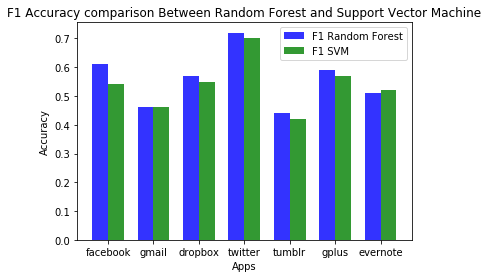

In [189]:
# data to plot
n_groups = 7
f1_rf = df_apps['f1_rf']
f1_svm = df_apps['f1_svm']

# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8


rects1 = plt.bar(index, f1_rf, bar_width,
alpha=opacity,
color='b',
label='F1 Random Forest')

rects2 = plt.bar(index + bar_width, f1_svm, bar_width,
alpha=opacity,
color='g',
label='F1 SVM')

plt.xlabel('Apps')
plt.ylabel('Accuracy')
plt.title('F1 Accuracy comparison Between Random Forest and Support Vector Machine')
plt.xticks(index + bar_width/2, apps)
plt.legend()


plt.show()